# Computer Vision Project
## INSTANCE 22 Challenge

### Team
1. Shaurya Dewan - 2019101017
2. Ashwin Rao - 2019101049
3. Harshwardhan Prasad - 20

### Importing Required Libraries and Basic Setup

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import time
import tqdm

In [2]:
import wandb
wandb.init(project="test-project", entity="whatever")

wandb: Currently logged in as: srdewan (whatever). Use `wandb login --relogin` to force relogin


In [3]:
print_config()

MONAI version: 0.9.0rc1+19.g61a0dc35
Numpy version: 1.22.4
Pytorch version: 1.11.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 61a0dc35b8a5edf78487b30c02c7aa0e51fc3409
MONAI __file__: /home/srd/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.1.1
Tensorboard version: 2.9.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
os.environ["MONAI_DATA_DIRECTORY"] = "./results"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./results


## Dataloader Setup

### Setting Datafiles' Paths

In [5]:
data_dir = "./data/train"
train_images = sorted(
    glob.glob(os.path.join(data_dir, "data", "*.nii.gz")))

train_labels = sorted(
    glob.glob(os.path.join(data_dir, "label", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [6]:
set_determinism(seed=0)

### Definition of Data Transforms

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=80,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 48),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 48),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=80,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

### Testing with Basic Dataloader

Dataloader Batch Dimensions =  torch.Size([8, 1, 96, 96, 48])
Original Scan Shape = torch.Size([96, 96, 48]), 
Segmented Scan Shape = torch.Size([96, 96, 48])
Unique Segmentation Mask Values =  [0. 1.]
Index = 2, Scan = 18


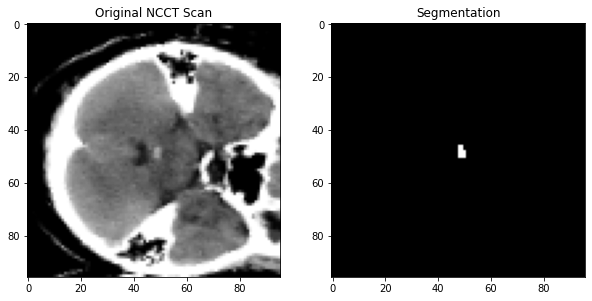

In [8]:
idx = 2
scan = 18

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2)
check_data = first(check_loader)
image, label = (check_data["image"][idx][0], check_data["label"][idx][0])

print("Dataloader Batch Dimensions = ", check_data["image"].shape)
print(f"Original Scan Shape = {image.shape}, \nSegmented Scan Shape = {label.shape}")
print("Unique Segmentation Mask Values = ", np.unique(label[:, :, scan]))

print("Index = %d, Scan = %d" % (idx, scan))
plt.figure("Testing", (10, 10))
plt.subplot(1, 2, 1)
plt.title("Original NCCT Scan")
plt.imshow(image[:, :, scan], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Segmentation")
plt.imshow(label[:, :, scan], cmap="gray")
plt.show()

### Train and Validation Dataloaders

In [9]:
train_batch_size = 4
val_batch_size = 1

# train_ds = Dataset(data=train_files, transform=train_transforms)
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, num_workers=4)

# val_ds = Dataset(data=val_files, transform=val_transforms)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=val_batch_size, num_workers=4)

Loading dataset: 100%|████████████████████████████| 9/9 [00:02<00:00,  3.70it/s]


### UNet Architecture Definition

In [10]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Bottleneck
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

NameError: name 'Input' is not defined

In [ ]:
from utils import *

class UNet_local(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return 

### Defining Training Essentials

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_res_units = 2
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=num_res_units,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

### Defining Training Hyperparameters

In [12]:
max_epochs = 100
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

wandb.config = {
    "epochs": max_epochs,
    "batch_size": train_batch_size,
    "num_res_units": num_res_units
}

### Training Loop

In [13]:
for epoch in tqdm.tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    start_time = time.time()
    
    for batch_data in tqdm.tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#         print(
#             f"{step}/{len(train_ds) // train_loader.batch_size}, "
#             f"train_loss: {loss.item():.4f}")
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    end_time = time.time()
    print("epoch time = %f seconds" % (end_time - start_time))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
    
                roi_size = (96, 96, 48)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            wandb.log({"loss": epoch_loss, "validation": metric})
            wandb.watch(model)
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
                
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

  0%|                                                   | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.62s/it]

epoch 1 average loss: 0.6707
epoch time = 83.224861 seconds



  1%|▍                                        | 1/100 [01:30<2:28:51, 90.22s/it]

saved new best metric model
current epoch: 1 current mean dice: 0.0160
best mean dice: 0.0160 at epoch: 1
----------
epoch 2/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.61s/it]

epoch 2 average loss: 0.6486
epoch time = 83.017658 seconds



  2%|▊                                        | 2/100 [03:00<2:27:21, 90.22s/it]

saved new best metric model
current epoch: 2 current mean dice: 0.0187
best mean dice: 0.0187 at epoch: 2
----------
epoch 3/100



100%|███████████████████████████████████████████| 23/23 [01:25<00:00,  3.70s/it]

epoch 3 average loss: 0.6357
epoch time = 85.156334 seconds



  3%|█▏                                       | 3/100 [04:32<2:27:25, 91.19s/it]

saved new best metric model
current epoch: 3 current mean dice: 0.0219
best mean dice: 0.0219 at epoch: 3
----------
epoch 4/100



100%|███████████████████████████████████████████| 23/23 [01:24<00:00,  3.66s/it]

epoch 4 average loss: 0.6272
epoch time = 84.297750 seconds



  4%|█▋                                       | 4/100 [06:04<2:26:06, 91.31s/it]

saved new best metric model
current epoch: 4 current mean dice: 0.0238
best mean dice: 0.0238 at epoch: 4
----------
epoch 5/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.60s/it]

epoch 5 average loss: 0.6192
epoch time = 82.754485 seconds



  5%|██                                       | 5/100 [07:34<2:23:41, 90.75s/it]

saved new best metric model
current epoch: 5 current mean dice: 0.0261
best mean dice: 0.0261 at epoch: 5
----------
epoch 6/100



100%|███████████████████████████████████████████| 23/23 [01:24<00:00,  3.69s/it]

epoch 6 average loss: 0.6116
epoch time = 84.836042 seconds



  6%|██▍                                      | 6/100 [09:06<2:23:12, 91.41s/it]

saved new best metric model
current epoch: 6 current mean dice: 0.0282
best mean dice: 0.0282 at epoch: 6
----------
epoch 7/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.58s/it]

epoch 7 average loss: 0.6051
epoch time = 82.339058 seconds



  7%|██▊                                      | 7/100 [10:36<2:20:36, 90.72s/it]

saved new best metric model
current epoch: 7 current mean dice: 0.0309
best mean dice: 0.0309 at epoch: 7
----------
epoch 8/100



100%|███████████████████████████████████████████| 23/23 [01:20<00:00,  3.50s/it]

epoch 8 average loss: 0.5978
epoch time = 80.589862 seconds



  8%|███▎                                     | 8/100 [12:03<2:17:34, 89.72s/it]

saved new best metric model
current epoch: 8 current mean dice: 0.0367
best mean dice: 0.0367 at epoch: 8
----------
epoch 9/100



100%|███████████████████████████████████████████| 23/23 [01:19<00:00,  3.46s/it]

epoch 9 average loss: 0.5913
epoch time = 79.482815 seconds



  9%|███▋                                     | 9/100 [13:30<2:14:49, 88.90s/it]

saved new best metric model
current epoch: 9 current mean dice: 0.0428
best mean dice: 0.0428 at epoch: 9
----------
epoch 10/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.53s/it]

epoch 10 average loss: 0.5853
epoch time = 81.266663 seconds



 10%|████                                    | 10/100 [14:59<2:13:09, 88.77s/it]

saved new best metric model
current epoch: 10 current mean dice: 0.0509
best mean dice: 0.0509 at epoch: 10
----------
epoch 11/100



100%|███████████████████████████████████████████| 23/23 [01:20<00:00,  3.52s/it]

epoch 11 average loss: 0.5785
epoch time = 80.918931 seconds



 11%|████▍                                   | 11/100 [16:27<2:11:22, 88.57s/it]

saved new best metric model
current epoch: 11 current mean dice: 0.0570
best mean dice: 0.0570 at epoch: 11
----------
epoch 12/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.60s/it]

epoch 12 average loss: 0.5732
epoch time = 82.743776 seconds



 12%|████▊                                   | 12/100 [17:57<2:10:26, 88.94s/it]

saved new best metric model
current epoch: 12 current mean dice: 0.1032
best mean dice: 0.1032 at epoch: 12
----------
epoch 13/100



100%|███████████████████████████████████████████| 23/23 [01:20<00:00,  3.51s/it]

epoch 13 average loss: 0.5677
epoch time = 80.766955 seconds



 13%|█████▏                                  | 13/100 [19:25<2:08:35, 88.68s/it]

current epoch: 13 current mean dice: 0.0856
best mean dice: 0.1032 at epoch: 12
----------
epoch 14/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.55s/it]

epoch 14 average loss: 0.5608
epoch time = 81.670538 seconds



 14%|█████▌                                  | 14/100 [20:53<2:07:06, 88.68s/it]

saved new best metric model
current epoch: 14 current mean dice: 0.1142
best mean dice: 0.1142 at epoch: 14
----------
epoch 15/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.54s/it]

epoch 15 average loss: 0.5556
epoch time = 81.473958 seconds



 15%|██████                                  | 15/100 [22:22<2:05:31, 88.61s/it]

saved new best metric model
current epoch: 15 current mean dice: 0.1296
best mean dice: 0.1296 at epoch: 15
----------
epoch 16/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.59s/it]

epoch 16 average loss: 0.5495
epoch time = 82.650395 seconds



 16%|██████▍                                 | 16/100 [23:52<2:04:35, 88.99s/it]

saved new best metric model
current epoch: 16 current mean dice: 0.1441
best mean dice: 0.1441 at epoch: 16
----------
epoch 17/100



100%|███████████████████████████████████████████| 23/23 [01:20<00:00,  3.50s/it]

epoch 17 average loss: 0.5441
epoch time = 80.503390 seconds



 17%|██████▊                                 | 17/100 [25:19<2:02:36, 88.63s/it]

current epoch: 17 current mean dice: 0.0833
best mean dice: 0.1441 at epoch: 16
----------
epoch 18/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.54s/it]

epoch 18 average loss: 0.5382
epoch time = 81.329304 seconds



 18%|███████▏                                | 18/100 [26:48<2:01:01, 88.56s/it]

saved new best metric model
current epoch: 18 current mean dice: 0.2292
best mean dice: 0.2292 at epoch: 18
----------
epoch 19/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.58s/it]

epoch 19 average loss: 0.5344
epoch time = 82.233412 seconds



 19%|███████▌                                | 19/100 [28:17<1:59:45, 88.71s/it]

current epoch: 19 current mean dice: 0.2110
best mean dice: 0.2292 at epoch: 18
----------
epoch 20/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.55s/it]

epoch 20 average loss: 0.5277
epoch time = 81.755313 seconds



 20%|████████                                | 20/100 [29:46<1:58:18, 88.74s/it]

current epoch: 20 current mean dice: 0.2021
best mean dice: 0.2292 at epoch: 18
----------
epoch 21/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.56s/it]

epoch 21 average loss: 0.5218
epoch time = 81.866153 seconds



 21%|████████▍                               | 21/100 [31:14<1:56:47, 88.70s/it]

saved new best metric model
current epoch: 21 current mean dice: 0.2772
best mean dice: 0.2772 at epoch: 21
----------
epoch 22/100



 96%|████████████████████████████████████████▏ | 22/23 [20:07<05:42, 342.08s/it]wandb: Network error (ConnectionError), entering retry loop.

100%|███████████████████████████████████████████| 23/23 [20:10<00:00, 52.65s/it]

epoch 22 average loss: 0.5193
epoch time = 1210.960557 seconds



wandb: Network error resolved after 0:00:07.795830, resuming normal operation.
 22%|████████▌                              | 22/100 [51:34<9:16:39, 428.20s/it]

current epoch: 22 current mean dice: 0.2057
best mean dice: 0.2772 at epoch: 21
----------
epoch 23/100



100%|███████████████████████████████████████████| 23/23 [01:26<00:00,  3.75s/it]

epoch 23 average loss: 0.5123
epoch time = 86.368590 seconds



 23%|████████▉                              | 23/100 [53:08<7:00:50, 327.93s/it]

current epoch: 23 current mean dice: 0.2199
best mean dice: 0.2772 at epoch: 21
----------
epoch 24/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.54s/it]

epoch 24 average loss: 0.5081
epoch time = 81.411427 seconds



 24%|█████████▎                             | 24/100 [54:37<5:24:21, 256.07s/it]

current epoch: 24 current mean dice: 0.1594
best mean dice: 0.2772 at epoch: 21
----------
epoch 25/100



100%|███████████████████████████████████████████| 23/23 [01:20<00:00,  3.50s/it]

epoch 25 average loss: 0.5026
epoch time = 80.470866 seconds



 25%|█████████▊                             | 25/100 [56:04<4:16:54, 205.53s/it]

current epoch: 25 current mean dice: 0.2750
best mean dice: 0.2772 at epoch: 21
----------
epoch 26/100



100%|███████████████████████████████████████████| 23/23 [01:19<00:00,  3.48s/it]

epoch 26 average loss: 0.4967
epoch time = 79.966488 seconds



 26%|██████████▏                            | 26/100 [57:31<3:29:38, 169.97s/it]

current epoch: 26 current mean dice: 0.2598
best mean dice: 0.2772 at epoch: 21
----------
epoch 27/100



100%|███████████████████████████████████████████| 23/23 [01:20<00:00,  3.52s/it]

epoch 27 average loss: 0.4905
epoch time = 80.940551 seconds



 27%|██████████▌                            | 27/100 [58:59<2:56:50, 145.35s/it]

current epoch: 27 current mean dice: 0.2723
best mean dice: 0.2772 at epoch: 21
----------
epoch 28/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.53s/it]

epoch 28 average loss: 0.4877
epoch time = 81.285743 seconds



 28%|██████████▎                          | 28/100 [1:00:28<2:33:51, 128.22s/it]

current epoch: 28 current mean dice: 0.2391
best mean dice: 0.2772 at epoch: 21
----------
epoch 29/100



100%|███████████████████████████████████████████| 23/23 [01:20<00:00,  3.48s/it]

epoch 29 average loss: 0.4768
epoch time = 80.132213 seconds



 29%|██████████▋                          | 29/100 [1:01:55<2:17:08, 115.90s/it]

saved new best metric model
current epoch: 29 current mean dice: 0.2972
best mean dice: 0.2972 at epoch: 29
----------
epoch 30/100



100%|███████████████████████████████████████████| 23/23 [01:21<00:00,  3.55s/it]

epoch 30 average loss: 0.4734
epoch time = 81.592560 seconds



 30%|███████████                          | 30/100 [1:03:24<2:05:47, 107.82s/it]

current epoch: 30 current mean dice: 0.2563
best mean dice: 0.2972 at epoch: 29
----------
epoch 31/100



100%|███████████████████████████████████████████| 23/23 [01:26<00:00,  3.77s/it]

epoch 31 average loss: 0.4685
epoch time = 86.607625 seconds



 31%|███████████▍                         | 31/100 [1:04:58<1:59:11, 103.64s/it]

current epoch: 31 current mean dice: 0.2820
best mean dice: 0.2972 at epoch: 29
----------
epoch 32/100



100%|███████████████████████████████████████████| 23/23 [01:31<00:00,  3.99s/it]

epoch 32 average loss: 0.4600
epoch time = 91.818255 seconds



 32%|███████████▊                         | 32/100 [1:06:38<1:56:21, 102.67s/it]

current epoch: 32 current mean dice: 0.2532
best mean dice: 0.2972 at epoch: 29
----------
epoch 33/100



100%|███████████████████████████████████████████| 23/23 [01:32<00:00,  4.01s/it]

epoch 33 average loss: 0.4554
epoch time = 92.128142 seconds



 33%|████████████▏                        | 33/100 [1:08:17<1:53:35, 101.72s/it]

current epoch: 33 current mean dice: 0.2874
best mean dice: 0.2972 at epoch: 29
----------
epoch 34/100



100%|███████████████████████████████████████████| 23/23 [01:28<00:00,  3.87s/it]

epoch 34 average loss: 0.4529
epoch time = 88.987633 seconds



 34%|████████████▌                        | 34/100 [1:09:54<1:50:14, 100.22s/it]

current epoch: 34 current mean dice: 0.2784
best mean dice: 0.2972 at epoch: 29
----------
epoch 35/100



100%|███████████████████████████████████████████| 23/23 [01:32<00:00,  4.02s/it]

epoch 35 average loss: 0.4449
epoch time = 92.391491 seconds



 35%|████████████▉                        | 35/100 [1:11:35<1:48:36, 100.25s/it]

saved new best metric model
current epoch: 35 current mean dice: 0.3221
best mean dice: 0.3221 at epoch: 35
----------
epoch 36/100



100%|███████████████████████████████████████████| 23/23 [01:31<00:00,  3.98s/it]

epoch 36 average loss: 0.4365
epoch time = 91.585917 seconds



 36%|█████████████▎                       | 36/100 [1:13:14<1:46:45, 100.08s/it]

current epoch: 36 current mean dice: 0.2518
best mean dice: 0.3221 at epoch: 35
----------
epoch 37/100



100%|███████████████████████████████████████████| 23/23 [01:32<00:00,  4.00s/it]

epoch 37 average loss: 0.4324
epoch time = 92.087564 seconds



 37%|█████████████▋                       | 37/100 [1:14:54<1:45:02, 100.05s/it]

current epoch: 37 current mean dice: 0.2785
best mean dice: 0.3221 at epoch: 35
----------
epoch 38/100



100%|███████████████████████████████████████████| 23/23 [01:36<00:00,  4.18s/it]

epoch 38 average loss: 0.4291
epoch time = 96.126642 seconds



 38%|██████████████                       | 38/100 [1:16:39<1:44:45, 101.38s/it]

current epoch: 38 current mean dice: 0.2801
best mean dice: 0.3221 at epoch: 35
----------
epoch 39/100



100%|███████████████████████████████████████████| 23/23 [01:33<00:00,  4.08s/it]

epoch 39 average loss: 0.4267
epoch time = 93.862430 seconds



 39%|██████████████▍                      | 39/100 [1:18:20<1:42:55, 101.23s/it]

current epoch: 39 current mean dice: 0.2885
best mean dice: 0.3221 at epoch: 35
----------
epoch 40/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.57s/it]

epoch 40 average loss: 0.4166
epoch time = 82.054168 seconds



 40%|███████████████▏                      | 40/100 [1:19:49<1:37:40, 97.67s/it]

current epoch: 40 current mean dice: 0.2344
best mean dice: 0.3221 at epoch: 35
----------
epoch 41/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.57s/it]

epoch 41 average loss: 0.4088
epoch time = 82.086024 seconds



 41%|███████████████▌                      | 41/100 [1:21:18<1:33:33, 95.14s/it]

current epoch: 41 current mean dice: 0.2748
best mean dice: 0.3221 at epoch: 35
----------
epoch 42/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.59s/it]

epoch 42 average loss: 0.4007
epoch time = 82.471782 seconds



 42%|███████████████▉                      | 42/100 [1:22:47<1:30:15, 93.38s/it]

current epoch: 42 current mean dice: 0.2953
best mean dice: 0.3221 at epoch: 35
----------
epoch 43/100



100%|███████████████████████████████████████████| 23/23 [01:30<00:00,  3.91s/it]

epoch 43 average loss: 0.4011
epoch time = 90.026013 seconds



 43%|████████████████▎                     | 43/100 [1:24:25<1:29:51, 94.59s/it]

current epoch: 43 current mean dice: 0.0987
best mean dice: 0.3221 at epoch: 35
----------
epoch 44/100



100%|███████████████████████████████████████████| 23/23 [01:33<00:00,  4.05s/it]

epoch 44 average loss: 0.3920
epoch time = 93.198636 seconds



 44%|████████████████▋                     | 44/100 [1:26:06<1:30:02, 96.47s/it]

current epoch: 44 current mean dice: 0.2662
best mean dice: 0.3221 at epoch: 35
----------
epoch 45/100



100%|███████████████████████████████████████████| 23/23 [01:31<00:00,  3.96s/it]

epoch 45 average loss: 0.3869
epoch time = 91.086906 seconds



 45%|█████████████████                     | 45/100 [1:27:44<1:29:02, 97.14s/it]

current epoch: 45 current mean dice: 0.2887
best mean dice: 0.3221 at epoch: 35
----------
epoch 46/100



100%|███████████████████████████████████████████| 23/23 [01:33<00:00,  4.08s/it]

epoch 46 average loss: 0.3883
epoch time = 93.749203 seconds



 46%|█████████████████▍                    | 46/100 [1:29:26<1:28:43, 98.58s/it]

saved new best metric model
current epoch: 46 current mean dice: 0.4463
best mean dice: 0.4463 at epoch: 46
----------
epoch 47/100



100%|███████████████████████████████████████████| 23/23 [01:35<00:00,  4.14s/it]

epoch 47 average loss: 0.3786
epoch time = 95.287571 seconds



 47%|█████████████████▊                    | 47/100 [1:31:09<1:28:17, 99.95s/it]

current epoch: 47 current mean dice: 0.2765
best mean dice: 0.4463 at epoch: 46
----------
epoch 48/100



100%|███████████████████████████████████████████| 23/23 [01:38<00:00,  4.30s/it]

epoch 48 average loss: 0.3738
epoch time = 98.895824 seconds



 48%|█████████████████▊                   | 48/100 [1:32:56<1:28:23, 101.99s/it]

current epoch: 48 current mean dice: 0.3201
best mean dice: 0.4463 at epoch: 46
----------
epoch 49/100



100%|███████████████████████████████████████████| 23/23 [01:36<00:00,  4.18s/it]

epoch 49 average loss: 0.3645
epoch time = 96.118432 seconds



 49%|██████████████████▏                  | 49/100 [1:34:41<1:27:16, 102.68s/it]

current epoch: 49 current mean dice: 0.3214
best mean dice: 0.4463 at epoch: 46
----------
epoch 50/100



100%|███████████████████████████████████████████| 23/23 [01:36<00:00,  4.21s/it]

epoch 50 average loss: 0.3606
epoch time = 96.907669 seconds



 50%|██████████████████▌                  | 50/100 [1:36:25<1:26:07, 103.36s/it]

current epoch: 50 current mean dice: 0.2926
best mean dice: 0.4463 at epoch: 46
----------
epoch 51/100



100%|███████████████████████████████████████████| 23/23 [01:36<00:00,  4.19s/it]

epoch 51 average loss: 0.3567
epoch time = 96.393881 seconds



 51%|██████████████████▊                  | 51/100 [1:38:10<1:24:46, 103.81s/it]

current epoch: 51 current mean dice: 0.3513
best mean dice: 0.4463 at epoch: 46
----------
epoch 52/100



100%|███████████████████████████████████████████| 23/23 [01:37<00:00,  4.24s/it]

epoch 52 average loss: 0.3543
epoch time = 97.439464 seconds



 52%|███████████████████▏                 | 52/100 [1:39:56<1:23:29, 104.37s/it]

current epoch: 52 current mean dice: 0.3197
best mean dice: 0.4463 at epoch: 46
----------
epoch 53/100



100%|███████████████████████████████████████████| 23/23 [01:36<00:00,  4.19s/it]

epoch 53 average loss: 0.3488
epoch time = 96.440997 seconds



 53%|███████████████████▌                 | 53/100 [1:41:41<1:21:53, 104.54s/it]

current epoch: 53 current mean dice: 0.3760
best mean dice: 0.4463 at epoch: 46
----------
epoch 54/100



100%|███████████████████████████████████████████| 23/23 [01:37<00:00,  4.25s/it]

epoch 54 average loss: 0.3434
epoch time = 97.672490 seconds



 54%|███████████████████▉                 | 54/100 [1:43:27<1:20:30, 105.00s/it]

current epoch: 54 current mean dice: 0.3260
best mean dice: 0.4463 at epoch: 46
----------
epoch 55/100



100%|███████████████████████████████████████████| 23/23 [01:39<00:00,  4.31s/it]

epoch 55 average loss: 0.3410
epoch time = 99.188711 seconds



 55%|████████████████████▎                | 55/100 [1:45:14<1:19:17, 105.72s/it]

saved new best metric model
current epoch: 55 current mean dice: 0.4592
best mean dice: 0.4592 at epoch: 55
----------
epoch 56/100



100%|███████████████████████████████████████████| 23/23 [01:35<00:00,  4.14s/it]

epoch 56 average loss: 0.3382
epoch time = 95.243850 seconds



 56%|████████████████████▋                | 56/100 [1:46:58<1:16:59, 104.98s/it]

current epoch: 56 current mean dice: 0.3396
best mean dice: 0.4592 at epoch: 55
----------
epoch 57/100



100%|███████████████████████████████████████████| 23/23 [01:32<00:00,  4.04s/it]

epoch 57 average loss: 0.3381
epoch time = 92.986629 seconds



 57%|█████████████████████                | 57/100 [1:48:38<1:14:18, 103.68s/it]

current epoch: 57 current mean dice: 0.2871
best mean dice: 0.4592 at epoch: 55
----------
epoch 58/100



100%|███████████████████████████████████████████| 23/23 [01:31<00:00,  3.99s/it]

epoch 58 average loss: 0.3292
epoch time = 91.806539 seconds



 58%|█████████████████████▍               | 58/100 [1:50:18<1:11:43, 102.45s/it]

current epoch: 58 current mean dice: 0.3898
best mean dice: 0.4592 at epoch: 55
----------
epoch 59/100



100%|███████████████████████████████████████████| 23/23 [01:29<00:00,  3.89s/it]

epoch 59 average loss: 0.3227
epoch time = 89.460352 seconds



 59%|█████████████████████▊               | 59/100 [1:51:55<1:08:51, 100.76s/it]

current epoch: 59 current mean dice: 0.3211
best mean dice: 0.4592 at epoch: 55
----------
epoch 60/100



100%|███████████████████████████████████████████| 23/23 [01:30<00:00,  3.91s/it]

epoch 60 average loss: 0.3183
epoch time = 90.031182 seconds



 60%|██████████████████████▊               | 60/100 [1:53:32<1:06:30, 99.77s/it]

current epoch: 60 current mean dice: 0.3641
best mean dice: 0.4592 at epoch: 55
----------
epoch 61/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.63s/it]

epoch 61 average loss: 0.3145
epoch time = 83.592288 seconds



 61%|███████████████████████▏              | 61/100 [1:55:03<1:03:08, 97.15s/it]

current epoch: 61 current mean dice: 0.3306
best mean dice: 0.4592 at epoch: 55
----------
epoch 62/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.64s/it]

epoch 62 average loss: 0.3080
epoch time = 83.787673 seconds



 62%|███████████████████████▌              | 62/100 [1:56:35<1:00:25, 95.40s/it]

current epoch: 62 current mean dice: 0.3697
best mean dice: 0.4592 at epoch: 55
----------
epoch 63/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.63s/it]

epoch 63 average loss: 0.3045
epoch time = 83.579977 seconds



 63%|█████████████████████████▏              | 63/100 [1:58:05<57:55, 93.94s/it]

current epoch: 63 current mean dice: 0.3036
best mean dice: 0.4592 at epoch: 55
----------
epoch 64/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.64s/it]

epoch 64 average loss: 0.3028
epoch time = 83.705387 seconds



 64%|█████████████████████████▌              | 64/100 [1:59:36<55:49, 93.05s/it]

current epoch: 64 current mean dice: 0.2548
best mean dice: 0.4592 at epoch: 55
----------
epoch 65/100



100%|███████████████████████████████████████████| 23/23 [01:27<00:00,  3.78s/it]

epoch 65 average loss: 0.2991
epoch time = 87.025029 seconds



 65%|██████████████████████████              | 65/100 [2:01:10<54:27, 93.35s/it]

current epoch: 65 current mean dice: 0.3795
best mean dice: 0.4592 at epoch: 55
----------
epoch 66/100



100%|███████████████████████████████████████████| 23/23 [01:27<00:00,  3.80s/it]

epoch 66 average loss: 0.3063
epoch time = 87.288428 seconds



 66%|██████████████████████████▍             | 66/100 [2:02:44<53:03, 93.65s/it]

current epoch: 66 current mean dice: 0.3303
best mean dice: 0.4592 at epoch: 55
----------
epoch 67/100



100%|███████████████████████████████████████████| 23/23 [01:30<00:00,  3.93s/it]

epoch 67 average loss: 0.2909
epoch time = 90.501332 seconds



 67%|██████████████████████████▊             | 67/100 [2:04:22<52:09, 94.84s/it]

current epoch: 67 current mean dice: 0.4475
best mean dice: 0.4592 at epoch: 55
----------
epoch 68/100



100%|███████████████████████████████████████████| 23/23 [01:28<00:00,  3.86s/it]

epoch 68 average loss: 0.2859
epoch time = 88.819484 seconds



 68%|███████████████████████████▏            | 68/100 [2:05:58<50:48, 95.26s/it]

current epoch: 68 current mean dice: 0.4062
best mean dice: 0.4592 at epoch: 55
----------
epoch 69/100



100%|███████████████████████████████████████████| 23/23 [01:28<00:00,  3.83s/it]

epoch 69 average loss: 0.2814
epoch time = 88.131144 seconds



 69%|███████████████████████████▌            | 69/100 [2:07:34<49:20, 95.51s/it]

saved new best metric model
current epoch: 69 current mean dice: 0.4662
best mean dice: 0.4662 at epoch: 69
----------
epoch 70/100



100%|███████████████████████████████████████████| 23/23 [01:29<00:00,  3.91s/it]

epoch 70 average loss: 0.2764
epoch time = 89.907970 seconds



 70%|████████████████████████████            | 70/100 [2:09:12<48:08, 96.29s/it]

current epoch: 70 current mean dice: 0.3820
best mean dice: 0.4662 at epoch: 69
----------
epoch 71/100



100%|███████████████████████████████████████████| 23/23 [01:26<00:00,  3.78s/it]

epoch 71 average loss: 0.2783
epoch time = 86.846244 seconds



 71%|████████████████████████████▍           | 71/100 [2:10:47<46:14, 95.68s/it]

current epoch: 71 current mean dice: 0.2950
best mean dice: 0.4662 at epoch: 69
----------
epoch 72/100



100%|███████████████████████████████████████████| 23/23 [01:25<00:00,  3.70s/it]

epoch 72 average loss: 0.2815
epoch time = 85.179067 seconds



 72%|████████████████████████████▊           | 72/100 [2:12:19<44:09, 94.63s/it]

current epoch: 72 current mean dice: 0.1712
best mean dice: 0.4662 at epoch: 69
----------
epoch 73/100



100%|███████████████████████████████████████████| 23/23 [01:27<00:00,  3.80s/it]

epoch 73 average loss: 0.2753
epoch time = 87.372820 seconds



 73%|█████████████████████████████▏          | 73/100 [2:13:54<42:41, 94.86s/it]

current epoch: 73 current mean dice: 0.3336
best mean dice: 0.4662 at epoch: 69
----------
epoch 74/100



100%|███████████████████████████████████████████| 23/23 [01:26<00:00,  3.75s/it]

epoch 74 average loss: 0.2773
epoch time = 86.241566 seconds



 74%|█████████████████████████████▌          | 74/100 [2:15:28<40:54, 94.39s/it]

current epoch: 74 current mean dice: 0.2187
best mean dice: 0.4662 at epoch: 69
----------
epoch 75/100



100%|███████████████████████████████████████████| 23/23 [01:32<00:00,  4.02s/it]

epoch 75 average loss: 0.2687
epoch time = 92.491697 seconds



 75%|██████████████████████████████          | 75/100 [2:17:09<40:10, 96.41s/it]

current epoch: 75 current mean dice: 0.2558
best mean dice: 0.4662 at epoch: 69
----------
epoch 76/100



100%|███████████████████████████████████████████| 23/23 [01:30<00:00,  3.95s/it]

epoch 76 average loss: 0.2611
epoch time = 90.837873 seconds



 76%|██████████████████████████████▍         | 76/100 [2:18:47<38:50, 97.09s/it]

current epoch: 76 current mean dice: 0.3195
best mean dice: 0.4662 at epoch: 69
----------
epoch 77/100



100%|███████████████████████████████████████████| 23/23 [01:54<00:00,  4.99s/it]

epoch 77 average loss: 0.2611
epoch time = 114.698896 seconds



 77%|██████████████████████████████         | 77/100 [2:20:50<40:06, 104.64s/it]

current epoch: 77 current mean dice: 0.2951
best mean dice: 0.4662 at epoch: 69
----------
epoch 78/100



100%|███████████████████████████████████████████| 23/23 [01:40<00:00,  4.37s/it]

epoch 78 average loss: 0.2701
epoch time = 100.495103 seconds



 78%|██████████████████████████████▍        | 78/100 [2:22:41<39:04, 106.58s/it]

current epoch: 78 current mean dice: 0.1909
best mean dice: 0.4662 at epoch: 69
----------
epoch 79/100



100%|███████████████████████████████████████████| 23/23 [01:25<00:00,  3.73s/it]

epoch 79 average loss: 0.2537
epoch time = 85.698994 seconds



 79%|██████████████████████████████▊        | 79/100 [2:24:13<35:50, 102.42s/it]

current epoch: 79 current mean dice: 0.3923
best mean dice: 0.4662 at epoch: 69
----------
epoch 80/100



100%|███████████████████████████████████████████| 23/23 [01:33<00:00,  4.08s/it]

epoch 80 average loss: 0.2500
epoch time = 93.778626 seconds



 80%|███████████████████████████████▏       | 80/100 [2:25:55<34:00, 102.01s/it]

current epoch: 80 current mean dice: 0.2977
best mean dice: 0.4662 at epoch: 69
----------
epoch 81/100



100%|███████████████████████████████████████████| 23/23 [01:29<00:00,  3.89s/it]

epoch 81 average loss: 0.2470
epoch time = 89.398870 seconds



 81%|███████████████████████████████▌       | 81/100 [2:27:32<31:53, 100.69s/it]

current epoch: 81 current mean dice: 0.4080
best mean dice: 0.4662 at epoch: 69
----------
epoch 82/100



100%|███████████████████████████████████████████| 23/23 [01:28<00:00,  3.87s/it]

epoch 82 average loss: 0.2464
epoch time = 88.904669 seconds



 82%|████████████████████████████████▊       | 82/100 [2:29:09<29:49, 99.43s/it]

current epoch: 82 current mean dice: 0.3806
best mean dice: 0.4662 at epoch: 69
----------
epoch 83/100



100%|███████████████████████████████████████████| 23/23 [01:26<00:00,  3.76s/it]

epoch 83 average loss: 0.2415
epoch time = 86.553394 seconds



 83%|█████████████████████████████████▏      | 83/100 [2:30:42<27:39, 97.60s/it]

current epoch: 83 current mean dice: 0.4426
best mean dice: 0.4662 at epoch: 69
----------
epoch 84/100



100%|███████████████████████████████████████████| 23/23 [01:25<00:00,  3.71s/it]

epoch 84 average loss: 0.2319
epoch time = 85.289668 seconds



 84%|█████████████████████████████████▌      | 84/100 [2:32:14<25:36, 96.00s/it]

saved new best metric model
current epoch: 84 current mean dice: 0.4776
best mean dice: 0.4776 at epoch: 84
----------
epoch 85/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.61s/it]

epoch 85 average loss: 0.2373
epoch time = 83.031594 seconds



 85%|██████████████████████████████████      | 85/100 [2:33:44<23:33, 94.23s/it]

current epoch: 85 current mean dice: 0.2268
best mean dice: 0.4776 at epoch: 84
----------
epoch 86/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.62s/it]

epoch 86 average loss: 0.2248
epoch time = 83.295183 seconds



 86%|██████████████████████████████████▍     | 86/100 [2:35:15<21:42, 93.03s/it]

current epoch: 86 current mean dice: 0.2875
best mean dice: 0.4776 at epoch: 84
----------
epoch 87/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.58s/it]

epoch 87 average loss: 0.2317
epoch time = 82.396478 seconds



 87%|██████████████████████████████████▊     | 87/100 [2:36:44<19:54, 91.89s/it]

current epoch: 87 current mean dice: 0.2897
best mean dice: 0.4776 at epoch: 84
----------
epoch 88/100



100%|███████████████████████████████████████████| 23/23 [01:42<00:00,  4.45s/it]

epoch 88 average loss: 0.2308
epoch time = 102.369060 seconds



 88%|███████████████████████████████████▏    | 88/100 [2:38:38<19:43, 98.64s/it]

current epoch: 88 current mean dice: 0.4060
best mean dice: 0.4776 at epoch: 84
----------
epoch 89/100



100%|███████████████████████████████████████████| 23/23 [01:34<00:00,  4.10s/it]

epoch 89 average loss: 0.2325
epoch time = 94.409536 seconds



 89%|███████████████████████████████████▌    | 89/100 [2:40:21<18:18, 99.84s/it]

current epoch: 89 current mean dice: 0.4375
best mean dice: 0.4776 at epoch: 84
----------
epoch 90/100



100%|███████████████████████████████████████████| 23/23 [01:41<00:00,  4.41s/it]

epoch 90 average loss: 0.2274
epoch time = 101.405521 seconds



 90%|███████████████████████████████████    | 90/100 [2:42:10<17:05, 102.50s/it]

current epoch: 90 current mean dice: 0.4112
best mean dice: 0.4776 at epoch: 84
----------
epoch 91/100



100%|███████████████████████████████████████████| 23/23 [01:33<00:00,  4.06s/it]

epoch 91 average loss: 0.2170
epoch time = 93.287617 seconds



 91%|███████████████████████████████████▍   | 91/100 [2:43:50<15:17, 101.92s/it]

saved new best metric model
current epoch: 91 current mean dice: 0.4799
best mean dice: 0.4799 at epoch: 91
----------
epoch 92/100



100%|███████████████████████████████████████████| 23/23 [01:24<00:00,  3.67s/it]

epoch 92 average loss: 0.2073
epoch time = 84.500909 seconds



 92%|████████████████████████████████████▊   | 92/100 [2:45:21<13:09, 98.70s/it]

saved new best metric model
current epoch: 92 current mean dice: 0.4821
best mean dice: 0.4821 at epoch: 92
----------
epoch 93/100



100%|███████████████████████████████████████████| 23/23 [01:29<00:00,  3.91s/it]

epoch 93 average loss: 0.2080
epoch time = 89.947198 seconds



 93%|█████████████████████████████████████▏  | 93/100 [2:46:58<11:27, 98.22s/it]

current epoch: 93 current mean dice: 0.4704
best mean dice: 0.4821 at epoch: 92
----------
epoch 94/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.61s/it]

epoch 94 average loss: 0.2035
epoch time = 83.145181 seconds



 94%|█████████████████████████████████████▌  | 94/100 [2:48:29<09:35, 95.89s/it]

saved new best metric model
current epoch: 94 current mean dice: 0.4857
best mean dice: 0.4857 at epoch: 94
----------
epoch 95/100



100%|███████████████████████████████████████████| 23/23 [01:29<00:00,  3.89s/it]

epoch 95 average loss: 0.1952
epoch time = 89.457453 seconds



 95%|██████████████████████████████████████  | 95/100 [2:50:06<08:00, 96.19s/it]

saved new best metric model
current epoch: 95 current mean dice: 0.4875
best mean dice: 0.4875 at epoch: 95
----------
epoch 96/100



100%|███████████████████████████████████████████| 23/23 [01:24<00:00,  3.67s/it]

epoch 96 average loss: 0.1998
epoch time = 84.523813 seconds



 96%|██████████████████████████████████████▍ | 96/100 [2:51:37<06:19, 94.83s/it]

current epoch: 96 current mean dice: 0.4677
best mean dice: 0.4875 at epoch: 95
----------
epoch 97/100



100%|███████████████████████████████████████████| 23/23 [01:25<00:00,  3.72s/it]

epoch 97 average loss: 0.1903
epoch time = 85.594727 seconds



 97%|██████████████████████████████████████▊ | 97/100 [2:53:10<04:42, 94.10s/it]

current epoch: 97 current mean dice: 0.4802
best mean dice: 0.4875 at epoch: 95
----------
epoch 98/100



100%|███████████████████████████████████████████| 23/23 [01:26<00:00,  3.74s/it]

epoch 98 average loss: 0.2019
epoch time = 86.010358 seconds



 98%|███████████████████████████████████████▏| 98/100 [2:54:43<03:07, 93.85s/it]

current epoch: 98 current mean dice: 0.4640
best mean dice: 0.4875 at epoch: 95
----------
epoch 99/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.62s/it]

epoch 99 average loss: 0.1918
epoch time = 83.364531 seconds



 99%|███████████████████████████████████████▌| 99/100 [2:56:14<01:32, 92.91s/it]

current epoch: 99 current mean dice: 0.4321
best mean dice: 0.4875 at epoch: 95
----------
epoch 100/100



  9%|███▊                                        | 2/23 [00:10<01:43,  4.91s/it]wandb: ERROR Summary data exceeds maximum size of 10.4MB. Dropping it.

100%|███████████████████████████████████████████| 23/23 [01:25<00:00,  3.71s/it]

epoch 100 average loss: 0.1990
epoch time = 85.413675 seconds



100%|██████████████████████████████████████| 100/100 [2:57:46<00:00, 106.67s/it]

current epoch: 100 current mean dice: 0.4832
best mean dice: 0.4875 at epoch: 95


In [14]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.4875 at epoch: 95


### Plotting Losses

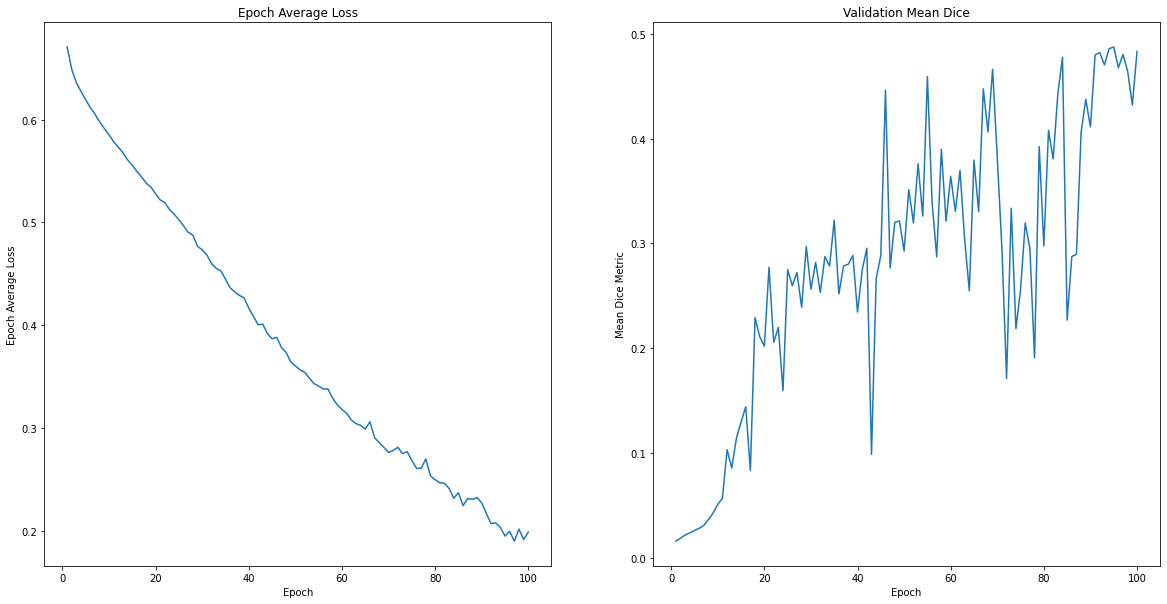

In [19]:
plt.figure("train", (20, 10))

plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Epoch")
plt.ylabel("Epoch Average Loss")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.ylabel("Mean Dice Metric")
plt.plot(x, y)
plt.show()

### Visualizing Validation Outputs

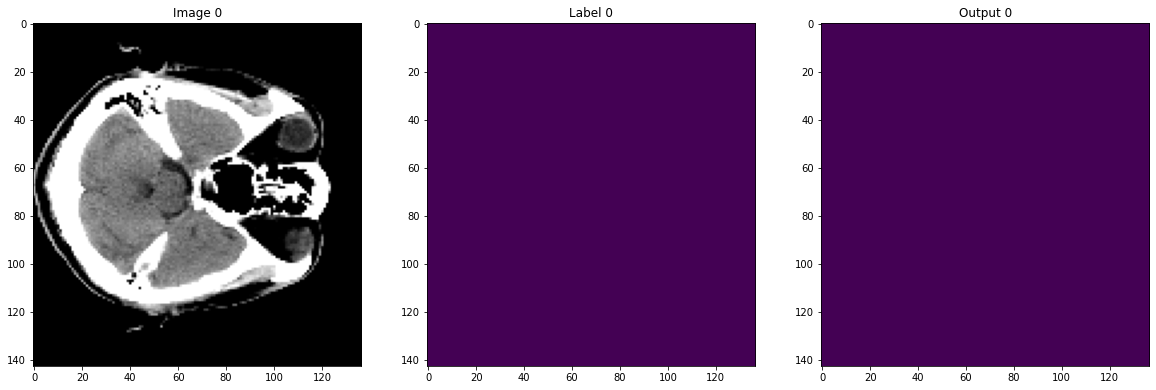

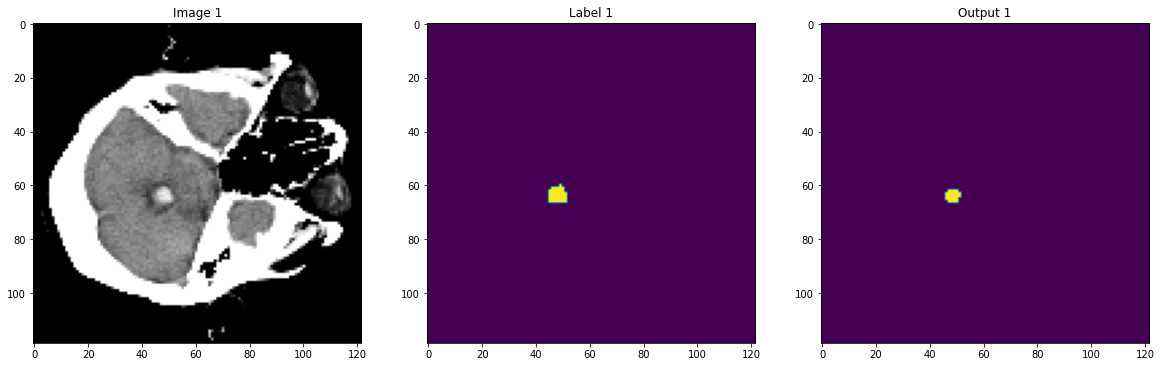

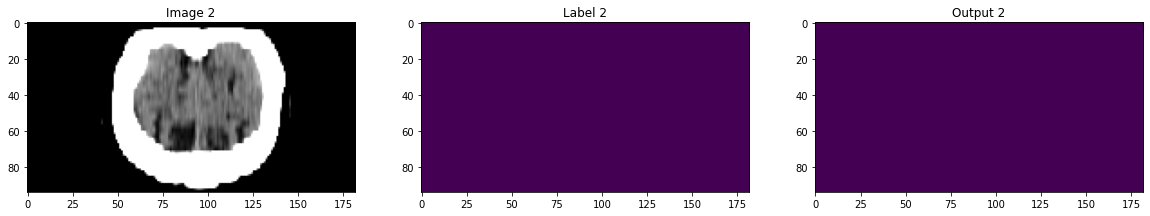

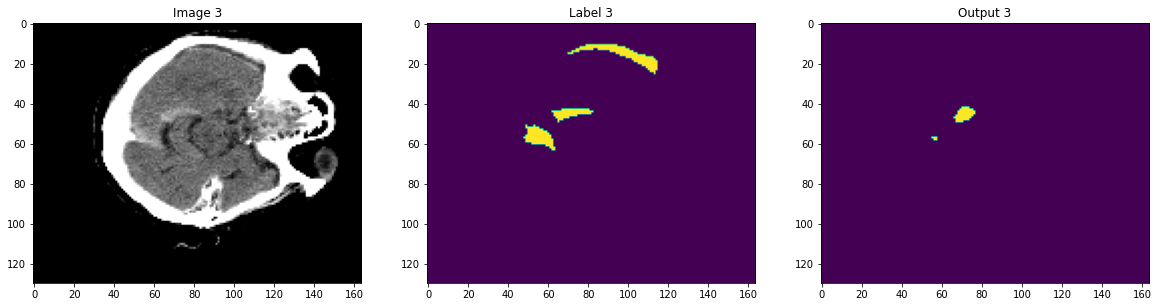

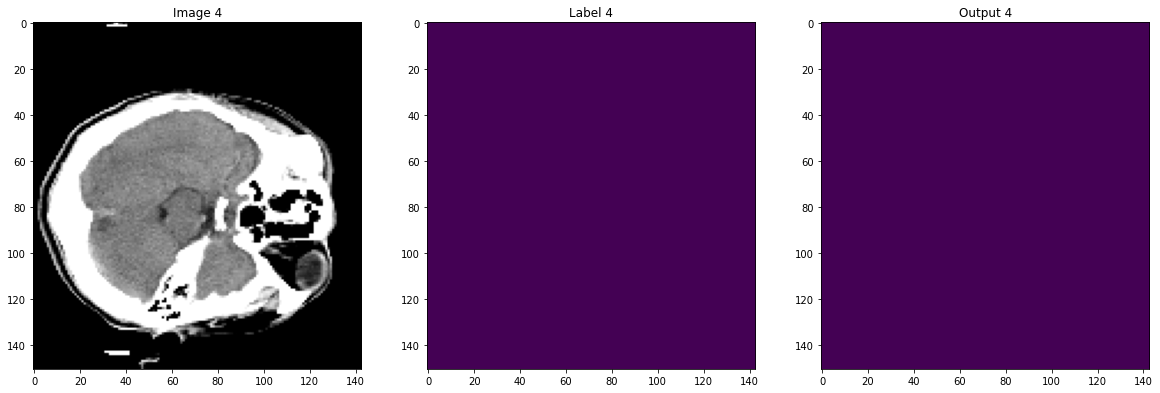

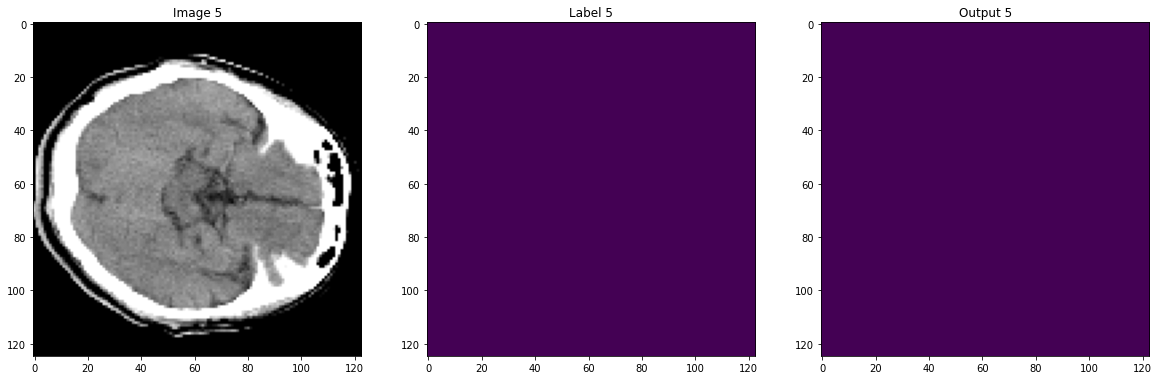

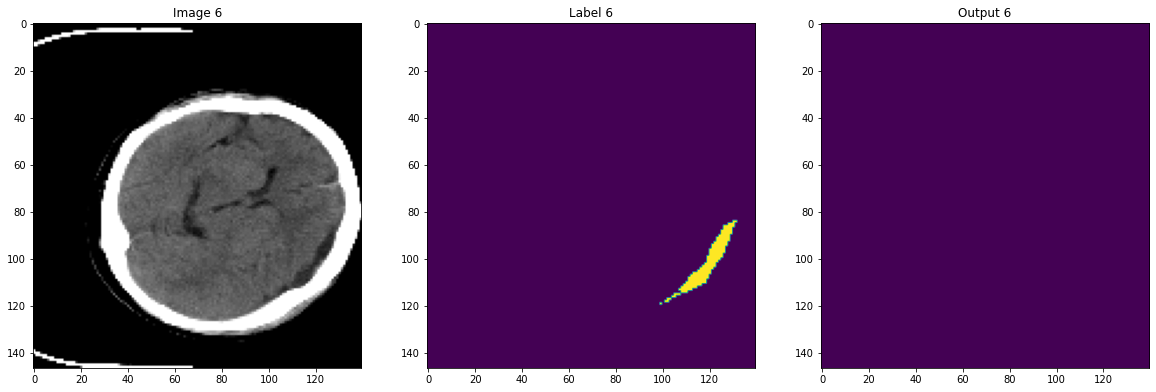

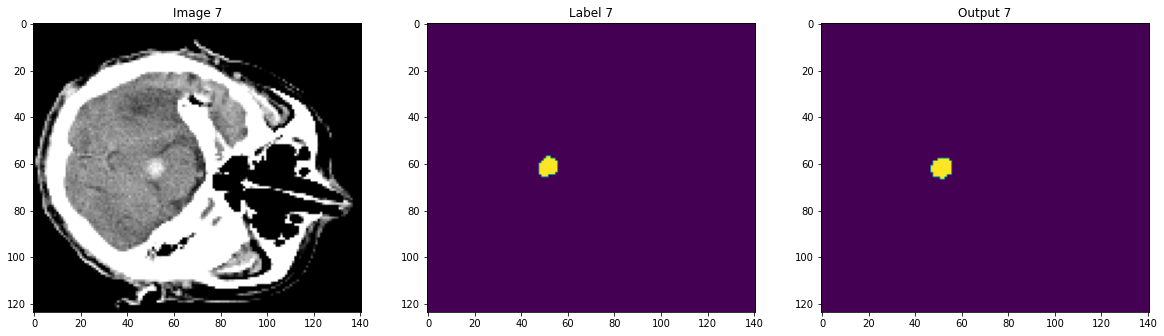

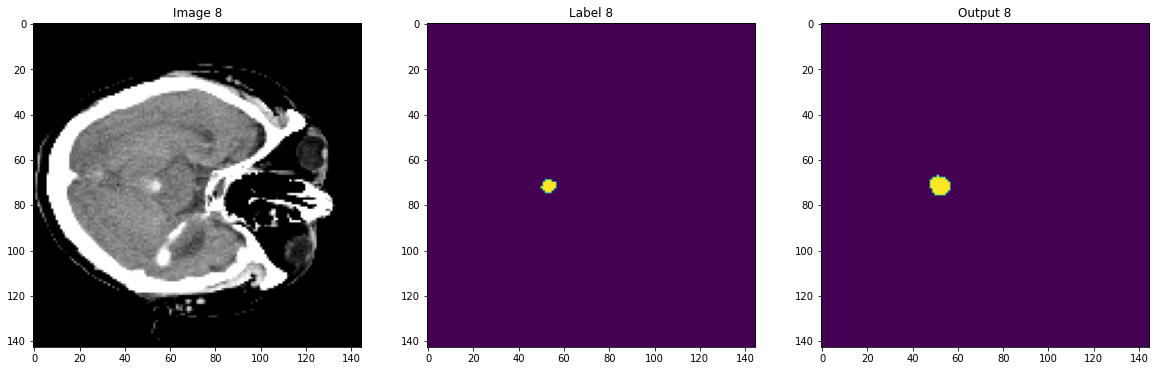

In [20]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
scan = 24

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 48)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )

        plt.figure("Check", (20, 10))
        plt.subplot(1, 3, 1)
        plt.title(f"Image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, scan], cmap="gray")
        
        plt.subplot(1, 3, 2)
        plt.title(f"Label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, scan])
        
        plt.subplot(1, 3, 3)
        plt.title(f"Output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, scan])
        plt.show()
        
        if i == 10:
            break